In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/CIS5810/Project2_Canny_Edge_Detection/

/content/drive/MyDrive/CIS5810/Project2_Canny_Edge_Detection


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from scipy import signal
from PIL import Image
import argparse

# Copy the path of the folder that contains this notebook using the file navigation on the left:
# Ex. /content/drive/MyDrive/Canny_Edge_Dectection
sys.path.append('/content/drive/MyDrive/CIS5810/Project2_Canny_Edge_Detection')

# import functions
from helpers import *

In [ ]:

#Test output correctness

def Test_script(I, E):
    test_pass = True

    # E should be 2D matrix
    if E.ndim != 2:
      print('ERROR: Incorrect Edge map dimension! \n')
      print(E.ndim)
      test_pass = False
    # end if

    # E should have same size with original image
    nr_I, nc_I = I.shape[0], I.shape[1]
    nr_E, nc_E = E.shape[0], E.shape[1]

    if nr_I != nr_E or nc_I != nc_E:
      print('ERROR: Edge map size has changed during operations! \n')
      test_pass = False
    # end if

    # E should be a binary matrix so that element should be either 1 or 0
    numEle = E.size
    numOnes, numZeros = E[E == 1].size, E[E == 0].size

    if numEle != (numOnes + numZeros):
      print('ERROR: Edge map is not binary one! \n')
      test_pass = False
    # end if

    if test_pass:
      print('Shape Test Passed! \n')
    else:
      print('Shape Test Failed! \n')

    return test_pass

In [ ]:

  # Derivatives visualzation function

def visDerivatives(I_gray, Mag, Magx, Magy):
    fig, (Ax0, Ax1, Ax2, Ax3) = plt.subplots(1, 4, figsize = (20, 8))

    Ax0.imshow(Mag, cmap='gray', interpolation='nearest')
    Ax0.axis('off')
    Ax0.set_title('Gradient Magnitude')

    Ax1.imshow(Magx, cmap='gray', interpolation='nearest')
    Ax1.axis('off')
    Ax1.set_title('Gradient Magnitude (x axis)')
    
    Ax2.imshow(Magy, cmap='gray', interpolation='nearest')
    Ax2.axis('off')
    Ax2.set_title('Gradient Magnitude (y axis)')

    # plot gradient orientation
    Mag_vec = Mag.transpose().reshape(1, Mag.shape[0] * Mag.shape[1]) 
    hist, bin_edge = np.histogram(Mag_vec.transpose(), 100)

    ind_array = np.array(np.where( (np.cumsum(hist).astype(float) / hist.sum()) < 0.95))
    thr = bin_edge[ind_array[0, -1]]

    ind_remove = np.where(np.abs(Mag) < thr)
    Magx[ind_remove] = 0
    Magy[ind_remove] = 0

    X, Y = np.meshgrid(np.arange(0, Mag.shape[1], 1), np.arange(0, Mag.shape[0], 1))
    Ori = np.arctan2(Magy, Magx)
    ori = Ax3.imshow(Ori, cmap='hsv')
    Ax3.axis('off')
    Ax3.set_title('Gradient Orientation')
    fig.colorbar(ori, ax=Ax3, )
    

#  Edge detection result visualization function

def visCannyEdge(Im_raw, M, E):
    # plot image
    fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize = (12, 12))

    # plot original image
    ax0.imshow(Im_raw)
    ax0.axis("off")
    ax0.set_title('Raw image')

    # plot edge detection result
    ax1.imshow(M, cmap='gray', interpolation='nearest')
    ax1.axis("off")
    ax1.set_title('Non-Max Suppression Result')

    # plot original image
    ax2.imshow(E, cmap='gray', interpolation='nearest')
    ax2.axis("off") 
    ax2.set_title('Canny Edge Detection')

In [ ]:

  # Convert RGB image to gray one manually. 
  - Input I_rgb: 3-dimensional rgb image
  - Output I_gray: 2-dimensional grayscale image

def rgb2gray(I_rgb):
    r, g, b = I_rgb[:, :, 0], I_rgb[:, :, 1], I_rgb[:, :, 2]
    I_gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return I_gray

In [ ]:
from scipy.signal.filter_design import math
def findDerivatives(I_gray):
    '''
    File clarification:
        Compute gradient information of the input grayscale image
        - Input I_gray: H x W matrix as image
        - Output Mag: H x W matrix represents the magnitude of derivatives
        - Output Magx: H x W matrix represents the magnitude of derivatives along x-axis
        - Output Magy: H x W matrix represents the magnitude of derivatives along y-axis
        - Output Ori: H x W matrix represents the orientation of derivatives
    '''
    #Filter defintions

    G = np.array([[2,4,5,4,2],[4,9,12,9,4],[5,12,15,12,5],[4,9,12,9,4],[2,4,5,4,2]])/159.0 #Gaussian kernel
    dx = np.array([[1,0,-1],[2,0,-2],[1,0,-1]]) #np.gradient(G,axis=1)#derivative in x
    dy = np.array([[1,2,1],[0,0,0],[-1,-2,-1]]) #np.gradient(G,axis=0)#derivative in y

    #Convolution of Gaussian with derivatives
    Gx = signal.convolve2d(G,dx,mode='same') #G convolved with dx
    Gy = signal.convolve2d(G,dy,mode='same')#G convolved with dy

    #Convolution of image with Gx and Gy (image gradient in x direciton and y direciton, respectively)

    Magx = signal.convolve2d(I_gray,Gx,mode='same')
    Magy = signal.convolve2d(I_gray,Gy,mode='same')

    #magnitude

    Mag = np.sqrt(np.add(np.multiply(Magx,Magx),np.multiply(Magy,Magy)))

    #orientation 
      #hint: see week 2 slide #84 for how to compute the ori - numpy will be helpful (https://numpy.org/doc/stable/reference/ufuncs.html)
    
    Ori = np.arctan2(Magy,Magx)

    return Mag, Magx, Magy, Ori

In [ ]:
def nonMaxSup(Mag, Ori):
  
    # - Input Mag: H x W matrix represents the magnitude of derivatives
    # - Input Ori: H x W matrix represents the orientation of derivatives
    # - Output M: H x W binary matrix represents the edge map after non-maximum suppression
    
    # getting neighbor in the oritention direction

    # using interpolation to get neighbor
    
    # getting neighbor in the opposite of the oritention direction
    
    # perform NMS
    #Meshgrid 
    
    nc = Mag.shape[1]
    nr = Mag.shape[0]

    x,y = np.meshgrid(np.arange(nc),np.arange(nr))

    x_neighbor = x+np.cos(Ori)
    y_neighbor = y+np.sin(Ori)

    Ori1= Ori +np.pi
 
    #neigbors in the other orientation direction

    x_neighbor2 = x+np.cos(Ori1)
    y_neighbor2 = y+np.sin(Ori1)
    
    # using interpolation to get neighbor

    neighbor1 = interp2(Mag, x_neighbor, y_neighbor)
    neighbor2 = interp2(Mag, x_neighbor2, y_neighbor2)

    neighbor1[np.around(y_neighbor)<0] = 0
    neighbor1[np.around(y_neighbor)>nr-1] = 0
    neighbor1[np.around(x_neighbor)<0] = 0
    neighbor1[np.around(x_neighbor)>nc-1] = 0

    neighbor2[np.around(y_neighbor2)<0] = 0
    neighbor2[np.around(y_neighbor2)>nr-1] = 0
    neighbor2[np.around(x_neighbor2)<0] = 0
    neighbor2[np.around(x_neighbor2)>nc-1] = 0

    
    # perform NMS - pseudo code below

    #2 - Vectorized
    M = np.logical_and(Mag >= neighbor1 , Mag >=neighbor2)
    
    return M

In [ ]:

# Canny edge detection main function

def cannyEdge(I, low, high):
    # convert RGB image to gray color space
    im_gray = rgb2gray(I)
    # Find gradient and perform NMS and edge linking
    Mag, Magx, Magy, Ori = findDerivatives(im_gray)
    M = nonMaxSup(Mag, Ori)
    E = edgeLink(M, Mag, Ori, low, high)

    # only when test passed that can show all results
    if Test_script(im_gray, E):
        # visualization results
        visDerivatives(im_gray, Mag, Magx, Magy)
        visCannyEdge(I, M, E)
        plt.show()

    return E

Shape Test Passed! 



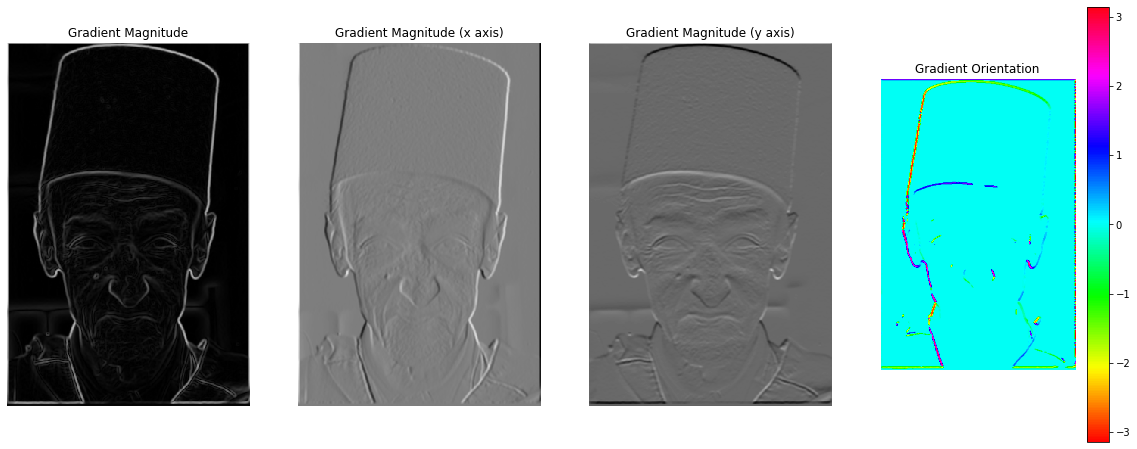

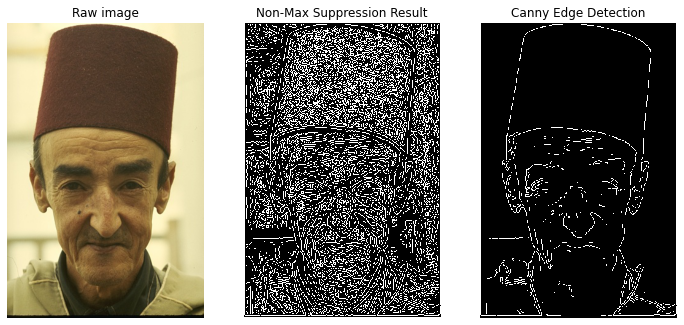

Shape Test Passed! 



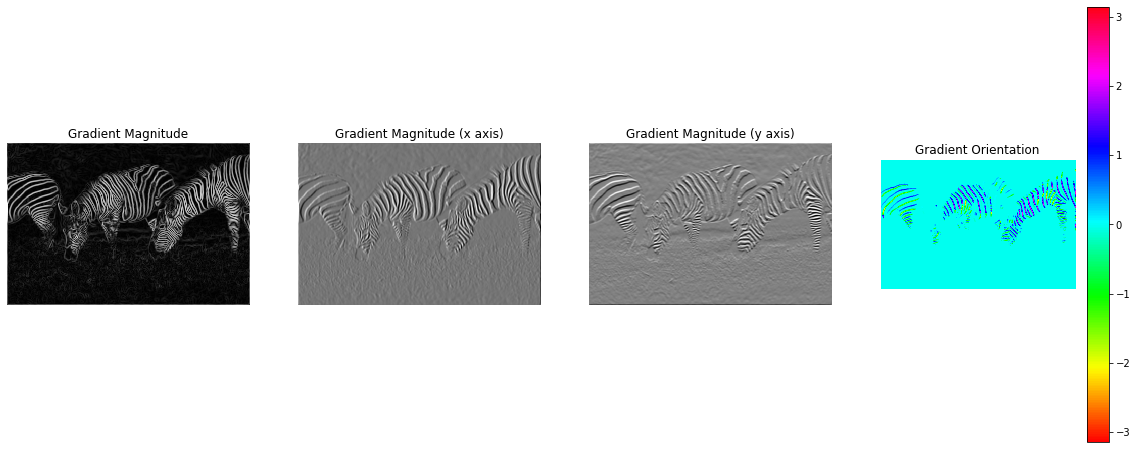

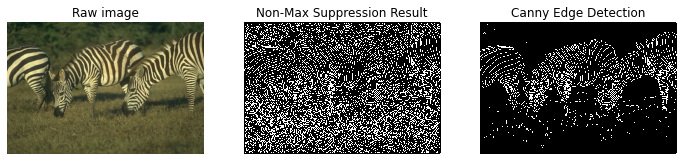

Shape Test Passed! 



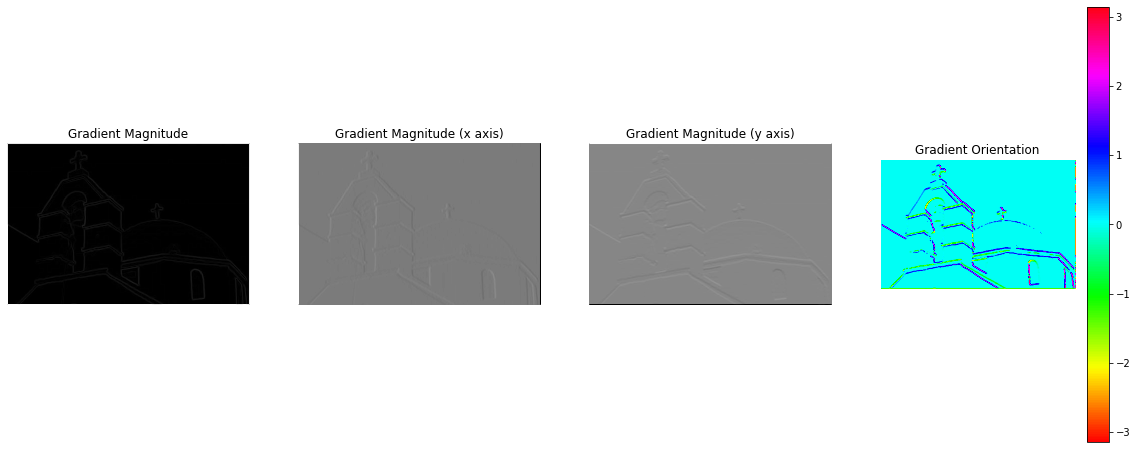

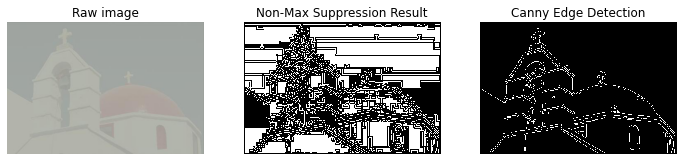

Shape Test Passed! 



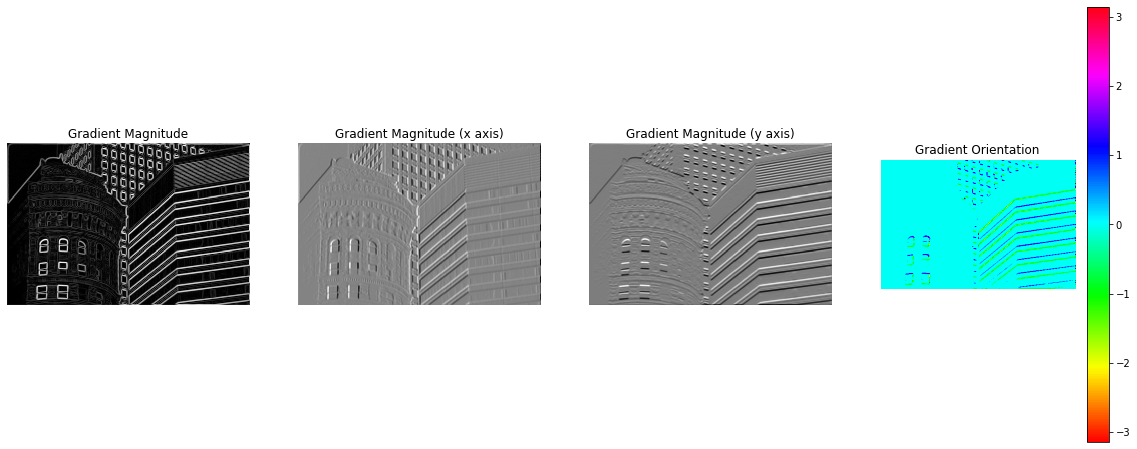

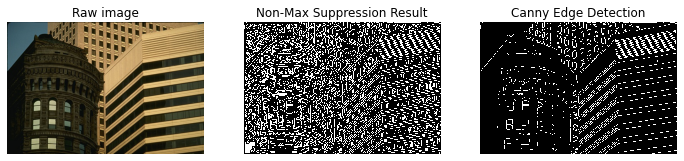

Shape Test Passed! 



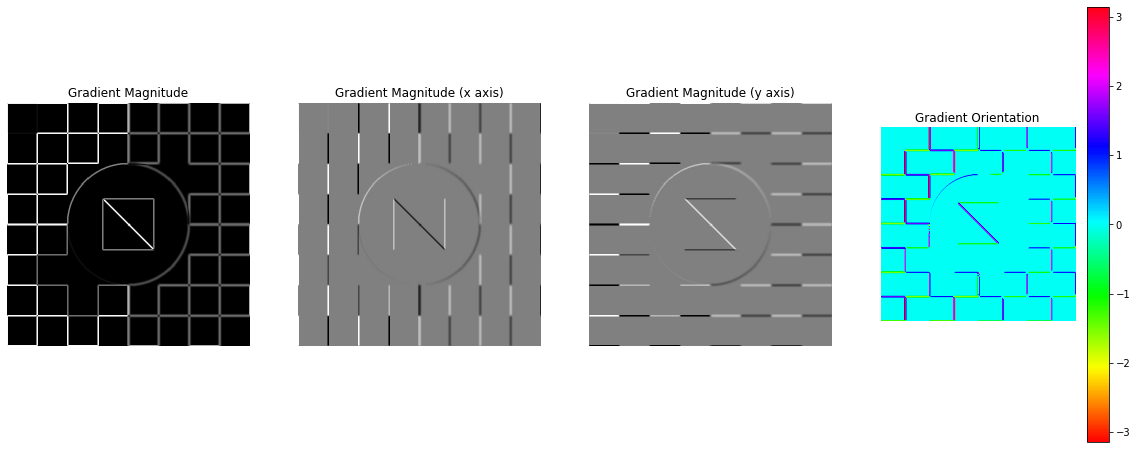

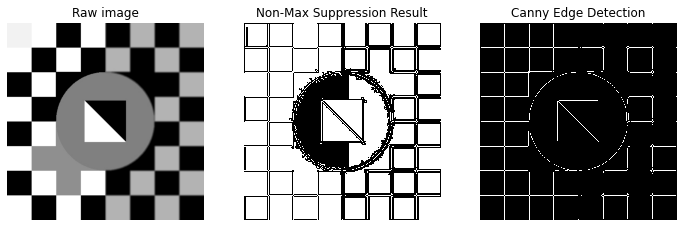

Shape Test Passed! 



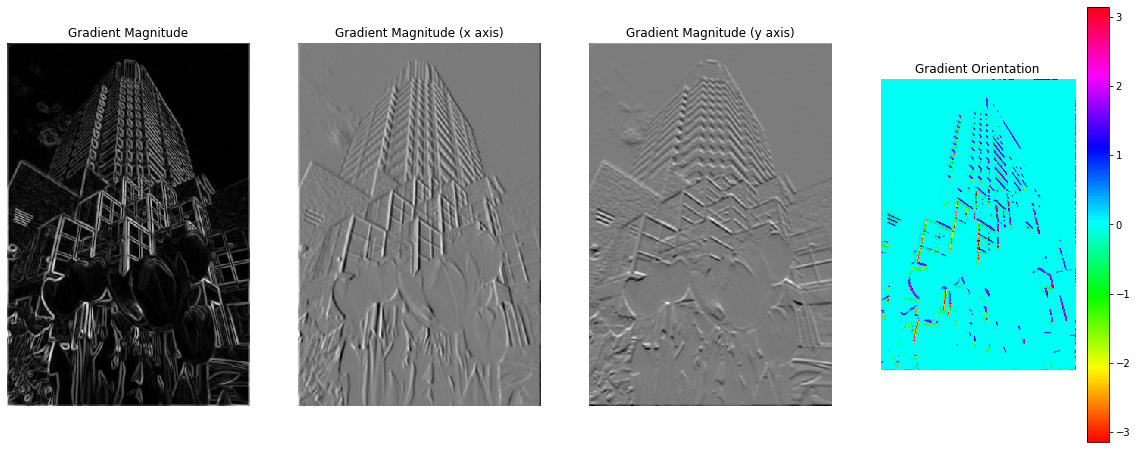

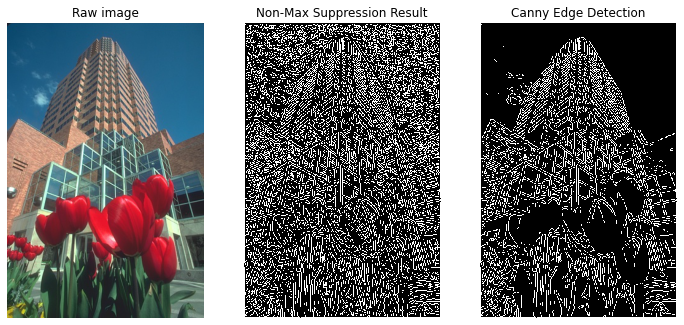

Shape Test Passed! 



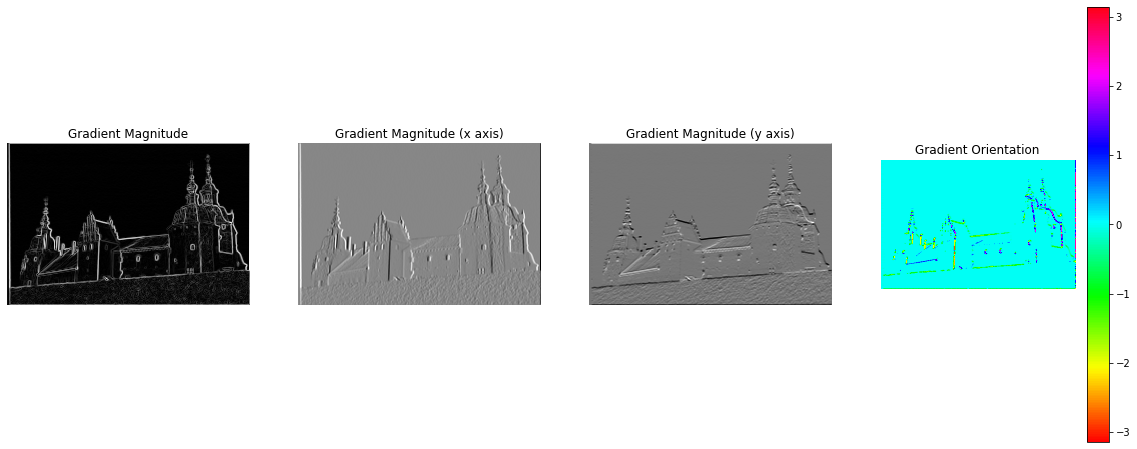

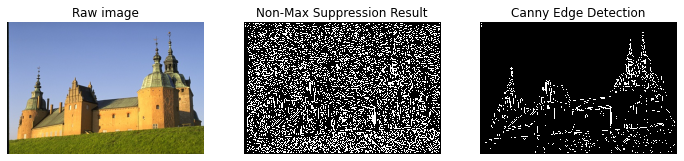

Shape Test Passed! 



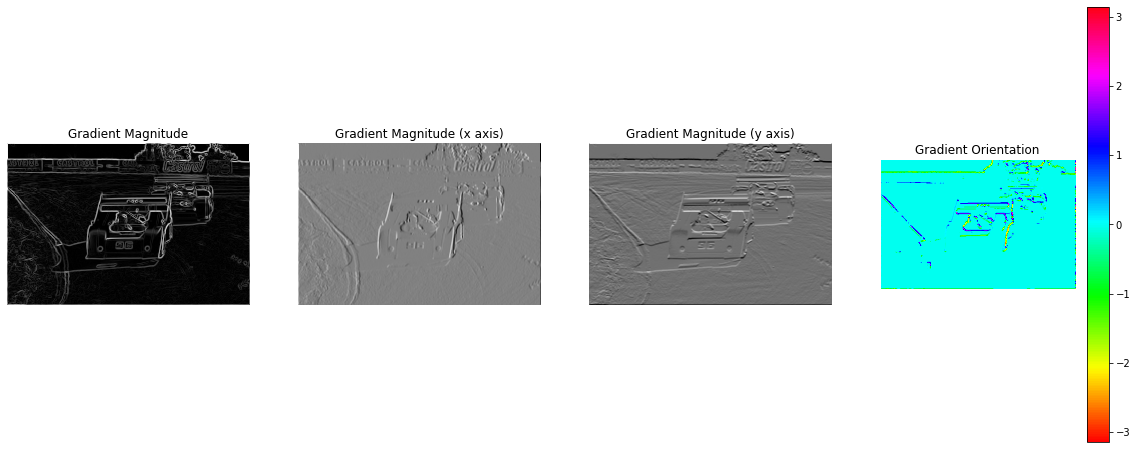

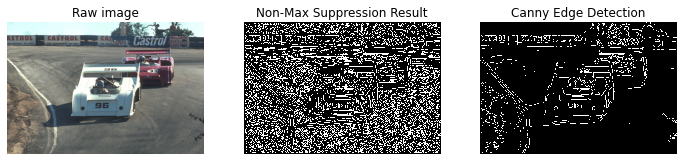

Shape Test Passed! 



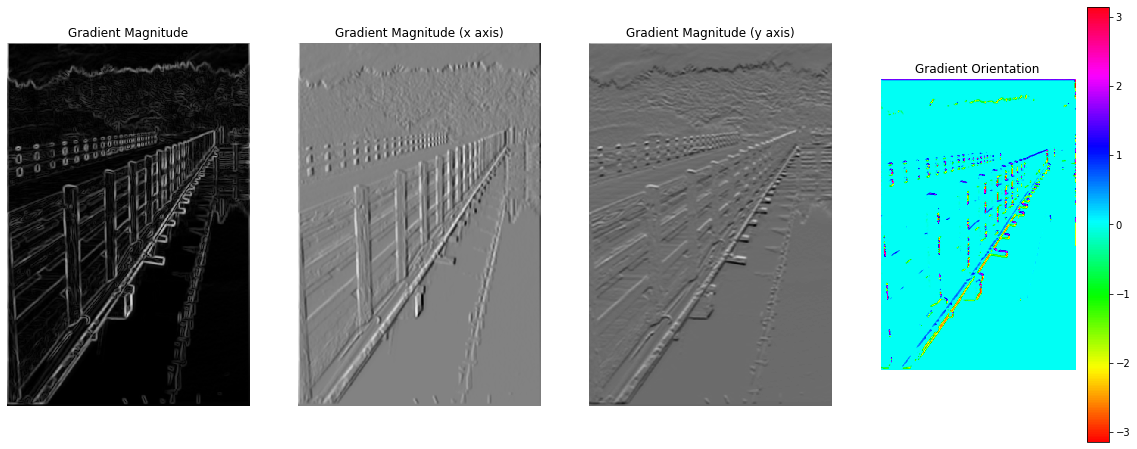

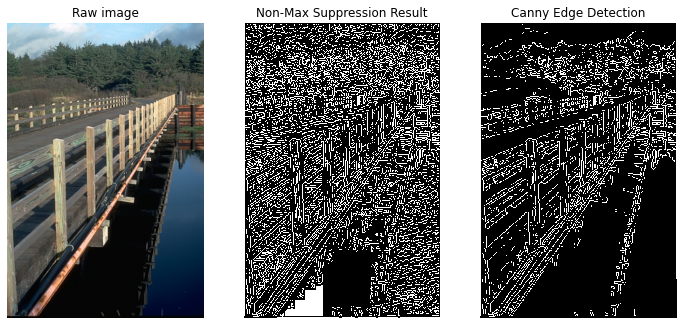

Shape Test Passed! 



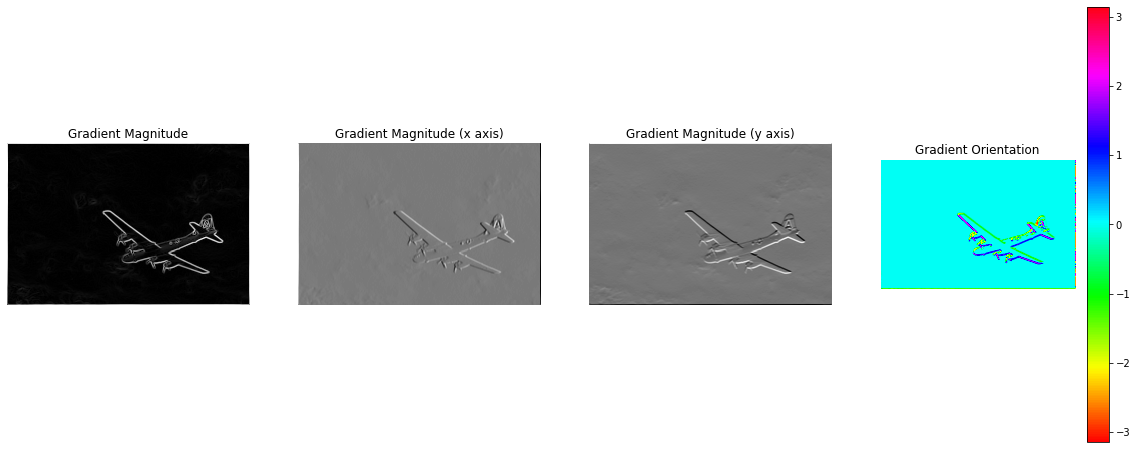

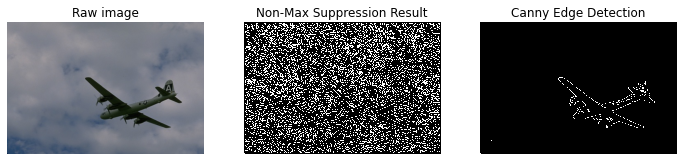

Shape Test Passed! 



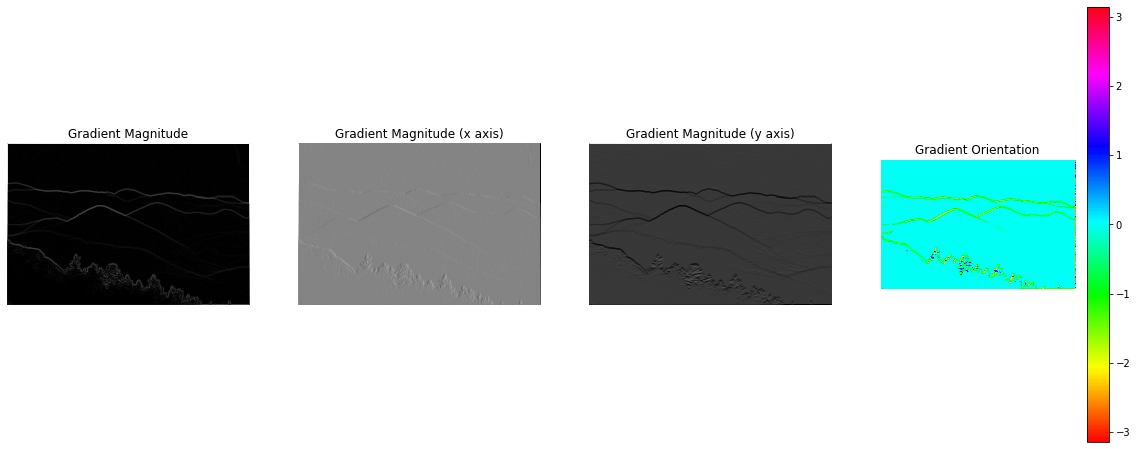

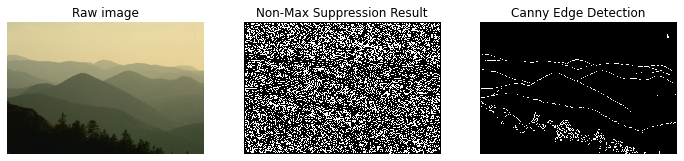

Shape Test Passed! 



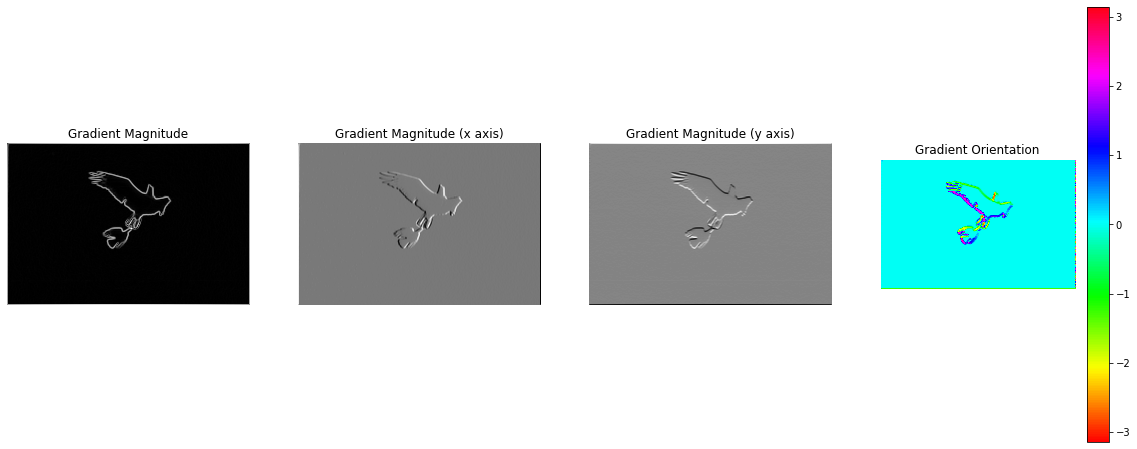

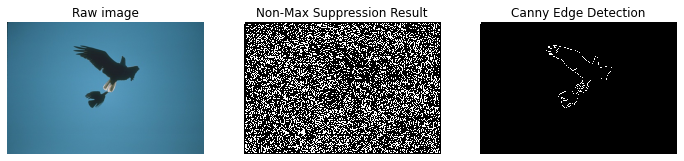

In [ ]:
# Fill in all tuned threshold to generate edge detection results
# keep results for all images
image_folder = "Images"
save_folder = "Results"
# fill in the threshold (low, high) you have tuned in the cell above 
thresh_dict = {'118035.jpg': (1, 4),
                '135069.jpg': (20, 63),
                '16068.jpg': (10, 45),
                '189080.jpg': (9, 43),
                '201080.jpg': (10, 47),
                '21077.jpg': (12, 54),
                '22013.jpg': (15, 30),
                '3096.jpg': (7, 35),
                '48017.jpg': (9, 60),
                '55067.jpg': (5, 12),
                '86000.jpg': (8, 22),
                'I1.jpg': (1, 12)}
# generate results one by one
for filename in os.listdir(image_folder):
    # read in image 
    im_path = os.path.join(image_folder, filename)
    I = np.array(Image.open(im_path).convert('RGB'))
    low, high = thresh_dict[filename]
    E = cannyEdge(I, low, high)
    pil_image = Image.fromarray(E.astype(np.uint8) * 255).convert('L')
    pil_image.save(os.path.join(save_folder, "{}_Result.png".format(filename.split(".")[0])))